In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
des=pd.read_csv('final_scraped.csv')

In [2]:
des.dropna(inplace=True)

In [3]:
def text_process(mess):
    import string
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [4]:
from nltk.stem import WordNetLemmatizer  
wordnet_lemmatizer=WordNetLemmatizer()
des['Description'].apply(lambda x: wordnet_lemmatizer.lemmatize(x))
des['Description'].apply(text_process)


0        [journey, Arunachal, North, East, India, begin...
1        [SUBSCRIBE, httpsgoogldEtSMJ, MountainTrekker,...
2        [chance, fly, Bali, whole, family, Thanksgivin...
3        [Hope, enjoy, GOA, TRAVEL, DIARY, video, Dont,...
4        [Travel, blogger, Nikki, Vargas, Pin, Map, Pro...
5        [video, explored, North, East, India, starting...
6        [Lisbon, quickly, became, one, favourite, citi...
7        [Welcome, Peru, essential, travel, guide, show...
8        [finally, vlog, brief, video, bhutan, uploadin...
9        [Create, Travel, Blog, Website, 395, httpbitly...
10       [travel, Peru, Machu, Picchu, Puno, Huacachina...
11       [Thank, much, watching, hope, found, travel, o...
12       [wife, traveled, 17, countries, 200, days, fil...
13       [Subscribe, httpsgoogl6zXZGK, Watch, full, ser...
14       [trip, ahead, time, learn, make, travel, video...
15       [Come, along, week, Paris, meant, post, little...
16       [SCARICA, LA, GUIDA, GRATUITA, PER, VIAGGIARE,.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(des['Description'])

In [7]:
vids_bow = bow_transformer.transform(des['Description'])

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(vids_bow)


In [9]:
vids_tfidf = tfidf_transformer.transform(vids_bow)

In [10]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)

In [11]:
from sklearn.model_selection import train_test_split
X=vids_tfidf
y=des['Category']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)


In [13]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
rfc_pred = rfc.predict(X_test)

In [15]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,rfc_pred))

               precision    recall  f1-score   support

          Art       0.83      0.77      0.80       564
         Food       0.85      0.82      0.83       574
      History       0.81      0.71      0.76       578
Manufacturing       0.56      0.87      0.68       542
      Science       0.83      0.67      0.74       593
       Travel       0.85      0.77      0.81       567

    micro avg       0.77      0.77      0.77      3418
    macro avg       0.79      0.77      0.77      3418
 weighted avg       0.79      0.77      0.77      3418



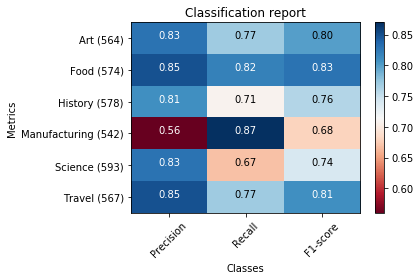

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]: 
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()


def main():

    sampleClassificationReport =(classification_report(y_test,rfc_pred))

    plot_classification_report(sampleClassificationReport)
    plt.show()
    plt.close()


if __name__ == '__main__':
    main()